In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10, 6) 
pd.set_option('use_inf_as_na', True)

In [33]:
liq_data=pd.read_csv('C:/Users/yim/Documents/카카오워크 받은 파일/mlfrm-master/bid_ask.csv')

In [34]:
liq_data.head()

,Unnamed: 0,Date,EXCHCD,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,OPENPRC,vwretx
0,1031570,2019-01-02,3.0,INTC,INTEL CORP,45.77,47.470,47.08,18761673.0,0.003196,4564000.0,45.960,0.001783
1,1031571,2019-01-03,3.0,INTC,INTEL CORP,44.39,46.280,44.49,32254097.0,-0.055013,4564000.0,46.150,-0.021219
2,1031572,2019-01-04,3.0,INTC,INTEL CORP,45.54,47.570,47.22,35419836.0,0.061362,4564000.0,45.835,0.033399
3,1031573,2019-01-07,3.0,INTC,INTEL CORP,46.75,47.995,47.44,22724997.0,0.004659,4564000.0,47.100,0.009191
4,1031574,2019-01-08,3.0,INTC,INTEL CORP,46.78,48.030,47.74,22721240.0,0.006324,4564000.0,47.800,0.010240


In [35]:
rolling_five=[]

for j in liq_data.TICKER.unique():
    for i in range(len(liq_data[liq_data.TICKER==j])):
        rolling_five.append(liq_data[i:i+5].agg({'BIDLO':'min',
        'ASKHI':'max',
        'VOL':'sum',
        'SHROUT':'mean',
        'PRC':'mean'}))

In [36]:
rolling_five_df=pd.DataFrame(rolling_five)
rolling_five_df.columns=['bidlo_min', 'askhi_max', 'vol_sum', 'shrout_mean', 'prc_mean']
liq_vol_all=pd.concat([liq_data, rolling_five_df], axis=1)

In [37]:
liq_ratio=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        liq_ratio.append((liq_vol_all['PRC'][i+1:i+6]*
        liq_vol_all['VOL'][i+1:i+6]).sum()/
        (np.abs(liq_vol_all['PRC'][i+1:i+6].mean()-
        liq_vol_all['PRC'][i:i+5].mean())))

In [38]:
Lhh=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        Lhh.append((liq_vol_all['PRC'][i:i+5].max()-
        liq_vol_all['PRC'][i:i+5].min())/
        liq_vol_all['PRC'][i:i+5].min()/
        (liq_vol_all['VOL'][i:i+5].sum()/
        liq_vol_all['SHROUT'][i:i+5].mean()*
        liq_vol_all['PRC'][i:i+5].mean()))

In [39]:
turnover_ratio=[]

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        turnover_ratio.append((1/liq_vol_all['VOL'].count())*
        (np.sum(liq_vol_all['VOL'][i:i+1])/
        np.sum(liq_vol_all['SHROUT'][i:i+1])))

In [40]:
liq_vol_all['liq_ratio']=pd.DataFrame(liq_ratio)
liq_vol_all['Lhh']=pd.DataFrame(Lhh)
liq_vol_all['turnover_ratio']=pd.DataFrame(turnover_ratio)

In [63]:
liq_vol_all['mid_price'] = (liq_vol_all.ASKHI + liq_vol_all.BIDLO) / 2
liq_vol_all['percent_quoted_ba'] = (liq_vol_all.ASKHI -
liq_vol_all.BIDLO)/\
    liq_vol_all.mid_price
liq_vol_all['percent_effective_ba'] = 2 * abs((liq_vol_all.PRC -
liq_vol_all.mid_price))/\
    liq_vol_all.mid_price

In [41]:
liq_vol_all['price_diff']=liq_vol_all.groupby('TICKER')['PRC']\
    .apply(lambda x:x.diff())
liq_vol_all.dropna(inplace=True)
roll=[]

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        roll_cov=np.cov(liq_vol_all['price_diff'][i:i+5],
        liq_vol_all['price_diff'][i+1:i+6])
        if roll_cov[0,1]<0:
            roll.append(2*np.sqrt(-roll_cov[0,1]))
        else:
            roll.append(2*np.sqrt(np.abs(roll_cov[0,1])))

            


In [42]:
gamma=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        gamma.append((max(liq_vol_all['ASKHI'].iloc[i+1],
        liq_vol_all['ASKHI'].iloc[i])-
        min(liq_vol_all['BIDLO'].iloc[i+1],
        liq_vol_all['BIDLO'].iloc[i]))**2)
        gamma_array=np.array(gamma)

In [43]:
beta=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        beta.append((liq_vol_all['ASKHI'].iloc[i+1]-
        liq_vol_all['BIDLO'].iloc[i+1])**2+
        (liq_vol_all['ASKHI'].iloc[i]-
        liq_vol_all['BIDLO'].iloc[i])**2)
        beta_array=np.array(beta)
        

In [44]:
alpha=((np.sqrt(2*beta_array)-np.sqrt(beta_array))/
(3-(2*np.sqrt(2))))-np.sqrt(gamma_array/
(3-(2*np.sqrt(2))))
CS_spread=(2*np.exp(alpha-1))/(1+np.exp(alpha))


In [45]:
liq_vol_all=liq_vol_all.reset_index()
liq_vol_all['roll']=pd.DataFrame(roll)
liq_vol_all['CS_spread']=pd.DataFrame(CS_spread)

In [46]:
dvol=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        dvol.append((liq_vol_all['PRC'][i:i+5]*
        liq_vol_all['VOL'][i:i+5]).sum())
liq_vol_all['dvol']=pd.DataFrame(dvol)


In [47]:
amihud=[]

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        amihud.append((1/liq_vol_all['RET'].count())*
        (np.sum(np.abs(liq_vol_all['RET'][i:i+1]))/
        np.sum(liq_vol_all['dvol'][i:i+1])))


In [48]:
florackis=[]

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        florackis.append((1/liq_vol_all['RET'].count())*
        (np.sum(np.abs(liq_vol_all['RET'][i:i+1])/
        liq_vol_all["turnover_ratio"][i:i+1])))

In [49]:
liq_vol_all['vol_diff_pct']=liq_vol_all.groupby('TICKER')['VOL']\
    .apply(lambda x: x.diff()).pct_change()
liq_vol_all['price_diff_pct']=liq_vol_all.groupby('TICKER')['PRC']\
    .apply(lambda x: x.diff()).pct_change()


In [50]:
cet=[]
for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER==j])):
        cet.append(np.sum(liq_vol_all['vol_diff_pct'][i:i+1])/
    np.sum(liq_vol_all['price_diff_pct'][i:i+1]))

In [51]:
liq_vol_all['amihud']=pd.DataFrame(amihud)
liq_vol_all['florackis']=pd.DataFrame(florackis)
liq_vol_all['cet']=pd.DataFrame(cet)


In [52]:
import statsmodels.api as sm 

In [53]:
liq_vol_all['VOL_pct_change']=liq_vol_all.groupby('TICKER')['VOL']\
    .apply(lambda x: x.pct_change())
liq_vol_all.dropna(subset=['VOL_pct_change'], inplace=True)
liq_vol_all=liq_vol_all.reset_index()

In [54]:
unsys_resid=[]

for i in liq_vol_all.TICKER.unique():
    X1=liq_vol_all[liq_vol_all['TICKER']==i]['vwretx']
    y=liq_vol_all[liq_vol_all['TICKER']==i]['RET']
    ols=sm.OLS(y, X1).fit()
    unsys_resid.append(ols.resid)

In [55]:
market_impact={}
for i, j in zip(liq_vol_all.TICKER.unique(),\
    range(len(liq_vol_all['TICKER'].unique()))):
    X2=liq_vol_all[liq_vol_all['TICKER']==i]['VOL_pct_change']
    ols=sm.OLS(unsys_resid[j]**2,X2).fit()
    print('***'*30)
    print(f'OLS Result for {i}')
    print(ols.summary())
    market_impact[j]=ols.resid 


******************************************************************************************
OLS Result for INTC
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.157
Model:                            OLS   Adj. R-squared (uncentered):              0.154
Method:                 Least Squares   F-statistic:                              46.31
Date:                Sun, 02 Apr 2023   Prob (F-statistic):                    7.53e-11
Time:                        21:28:56   Log-Likelihood:                          1444.9
No. Observations:                 249   AIC:                                     -2888.
Df Residuals:                     248   BIC:                                     -2884.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
         

In [56]:
append1=market_impact[0].append(market_impact[1])
liq_vol_all['market_impact']=append1.append(market_impact[2])


In [64]:
cols=['vol_diff_pct', 'price_diff_pct', 'price_diff', 'VOL_pct_change', 'dvol', 'mid_price']
liq_measures_all=liq_vol_all.drop(liq_vol_all[cols], axis=1)\
    .iloc[:, -11:]
liq_measures_all.dropna(inplace=True)
liq_measures_all.describe().T 

,count,mean,std,min,25%,50%,75%,max
liq_ratio,738.0,7.368514e+10,2.569030e+11,8.065402e+08,1.378496e+10,2.261858e+10,4.505784e+10,3.095986e+12
Lhh,738.0,3.340167e-05,5.371681e-05,3.966368e-06,1.694354e-05,2.368095e-05,3.558960e-05,5.824148e-04
turnover_ratio,738.0,6.491127e-03,2.842668e-03,1.916371e-03,4.897990e-03,5.764112e-03,7.423111e-03,2.542853e-02
roll,738.0,8.190794e-01,6.066821e-01,7.615773e-02,4.574986e-01,6.975982e-01,1.011879e+00,4.178873e+00
CS_spread,738.0,3.305464e-01,1.267434e-01,1.773438e-40,2.444225e-01,3.609800e-01,4.188028e-01,5.877726e-01
amihud,738.0,2.777021e-15,2.319450e-15,0.000000e+00,1.117729e-15,2.220439e-15,3.766086e-15,1.320828e-14
florackis,738.0,2.284291e-03,1.546181e-03,0.000000e+00,1.059446e-03,2.013517e-03,3.324181e-03,7.869841e-03
cet,738.0,-1.113583e+00,3.333932e+01,-4.575246e+02,-1.687807e-01,5.654237e-01,1.660166e+00,1.845917e+02
market_impact,738.0,8.614680e-05,5.087547e-04,-1.596135e-03,-3.010645e-05,3.383862e-05,1.309451e-04,8.165527e-03
percent_quoted_ba,738.0,1.565276e-02,7.562850e-03,3.779877e-03,1.041887e-02,1.379992e-02,1.878123e-02,5.545110e-02


In [65]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler 


In [66]:
liq_measures_all2=liq_measures_all.dropna()
scaled_liq=StandardScaler().fit_transform(liq_measures_all2)


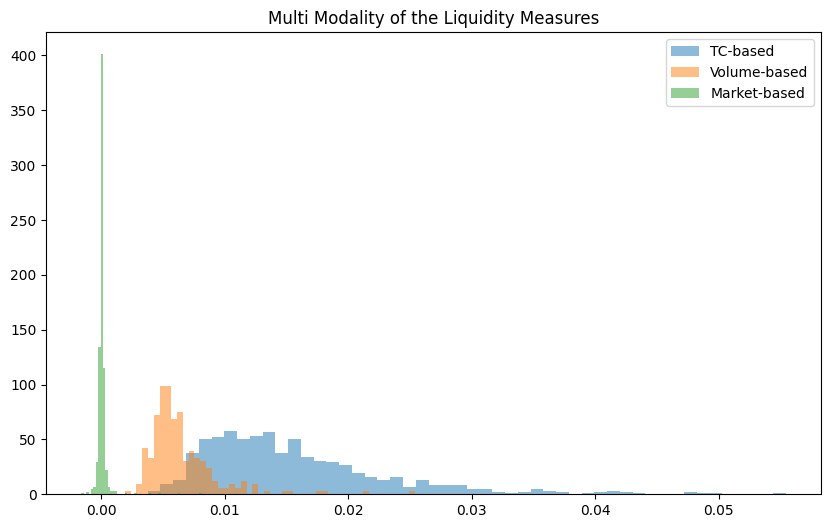

In [67]:
kwargs=dict(alpha=0.5, bins=50, stacked=True)
plt.hist(liq_measures_all.loc[:, 'percent_quoted_ba'],
**kwargs, label='TC-based')
plt.hist(liq_measures_all.loc[:, 'turnover_ratio'],
**kwargs, label='Volume-based')
plt.hist(liq_measures_all.loc[:, 'market_impact'],
**kwargs,label='Market-based')
plt.title('Multi Modality of the Liquidity Measures')
plt.legend()
plt.show()

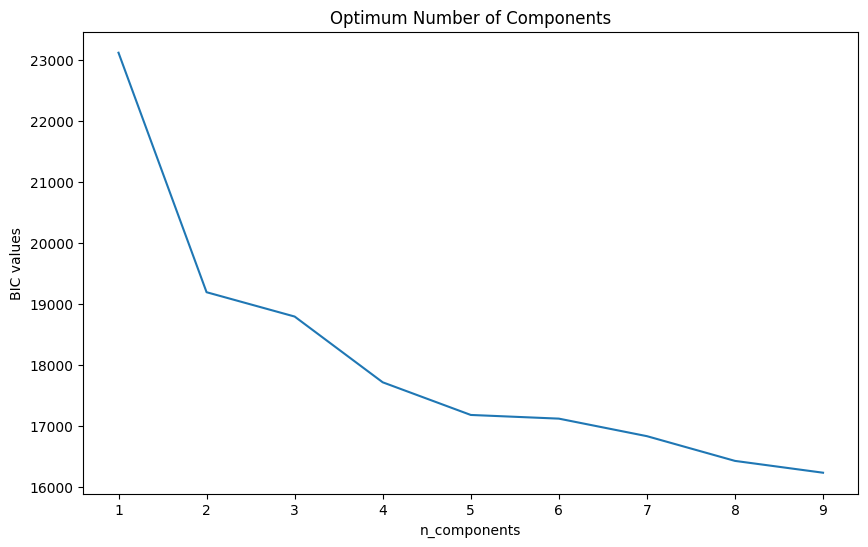

In [68]:
n_components=np.arange(1,10)
clusters=[GaussianMixture(n, covariance_type='spherical',
random_state=0).fit(scaled_liq)
for n in n_components]
plt.plot(n_components, [m.bic(scaled_liq) for m in clusters])
plt.title('Optimum Number of Components')
plt.xlabel('n_components')
plt.ylabel('BIC values')
plt.show()


In [69]:
def cluster_state(data, nstates):
    gmm=GaussianMixture(n_components=nstates,
    covariance_type='spherical',
    init_params='kmeans')
    gmm_fit=gmm.fit(scaled_liq)
    labels=gmm_fit.predict(scaled_liq)
    state_probs=gmm.predict_proba(scaled_liq)
    state_probs_df=pd.DataFrame(state_probs, 
    columns=['state-1', 'state-2', 'state-3'])
    state_prob_means=[state_probs_df.iloc[:,i].mean()
    for i in range(len(state_probs_df.columns))]
    if np.max(state_prob_means)==state_prob_means[0]:
        print('State-1 is likely to occur with a probability of {:4f}'.format(state_prob_means[0]))
    elif np.max(state_prob_means)==state_prob_means[1]:
        print('State-2 is likely to occur with a probability of {:4f}'.format(state_prob_means[1]))
    else:
        print('State-3 is likely to occur with a probability of {:4f}'.format(state_prob_means[2]))
    return state_probs 

In [70]:
state_probs=cluster_state(scaled_liq, 3)
print(f'State probabilities are {state_probs.mean(axis=0)}')

State-3 is likely to occur with a probability of 0.549953
State probabilities are [0.38713538 0.06291121 0.54995341]


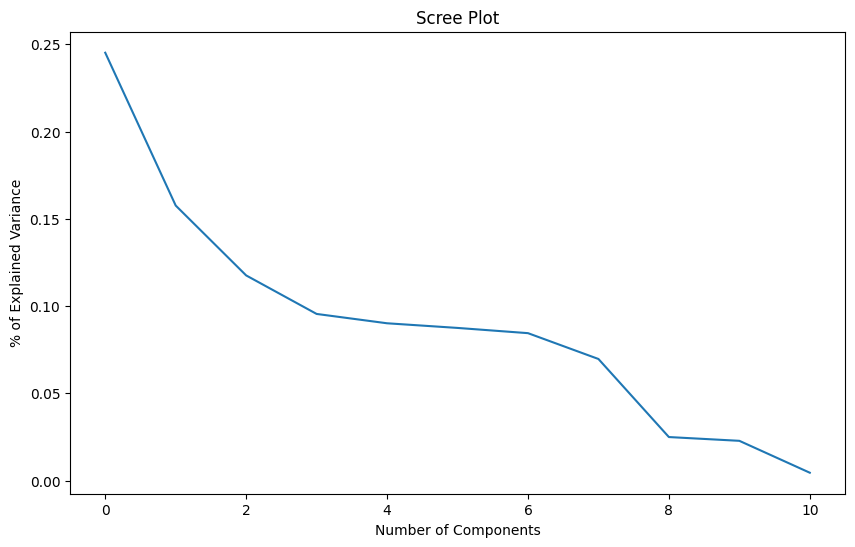

In [71]:
from sklearn.decomposition import PCA 

pca=PCA(n_components=11)
components=pca.fit_transform(scaled_liq)
plt.plot(pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('% of Explained Variance')
plt.show()

In [74]:
def gmm_pca(data, nstate):
    pca=PCA(n_components=3)
    components=pca.fit_transform(data)
    mxtd=GaussianMixture(n_components=nstate, covariance_type='spherical')
    gmm=mxtd.fit(components)
    labels=gmm.predict(components)
    state_probs=gmm.predict_proba(components)
    return state_probs, pca 



In [75]:
state_probs, pca=gmm_pca(scaled_liq, 3)
print(f'State probabilities are {state_probs.mean(axis=0)}')

State probabilities are [0.01626015 0.24913847 0.73460138]


In [81]:
compo

array([[9.31402915e-30, 3.93192273e-02, 9.60680773e-01],
       [4.69720066e-27, 2.91446997e-01, 7.08553003e-01],
       [1.55509285e-33, 8.43360623e-02, 9.15663938e-01],
       ...,
       [1.00000000e+00, 2.10084170e-10, 3.88534013e-32],
       [9.99993949e-01, 6.05079723e-06, 2.19210255e-22],
       [9.99999435e-01, 5.65415554e-07, 4.32335123e-23]])

In [77]:
def wpc():
    state_probs_df=pd.DataFrame(state_probs, columns=['state-1', 'state-2', 'state-3'])
    state_prob_means=[state_probs_df.iloc[:,i].mean()
    for i in range(len(state_probs_df.columns))]
    if np.max(state_prob_means)==state_prob_means[0]:
        print('State-1 is likely to occur with a probability of {:4f}'.format(state_prob_means[0]))
    elif np.max(state_prob_means)==state_prob_means[1]:
        print('State-2 is likely to occur with a probability of {:4f}'.format(state_prob_means[1]))
    else:
        print('State-3 is likely to occur with a probability of {:4f}'.format(state_prob_means[2]))

wpc()

State-3 is likely to occur with a probability of 0.734601
